In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import mysql.connector
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
# Cargar las variables de entorno del archivo .env

# In[2]:

load_dotenv()
db_host = os.getenv('DB_HOST')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_name = os.getenv('DB_NAME')

In [3]:
# Conectar a la base de datos MySQL

# In[3]:

conn = mysql.connector.connect(
    host=db_host,
    user=db_user,
    password=db_password,
    database=db_name
)

In [4]:
query = """
SELECT sku, user_id, created_at, total_orden 
FROM order_main where 
    created_at >= DATE_SUB(CURDATE(), INTERVAL 1 YEAR)
    AND created_at < DATE_FORMAT(CURDATE(), '%Y-%m-01');
"""

df = pd.read_sql(query, conn)

In [5]:
df.columns = ['SKU', 'USUARIO', 'FECHA', 'VENTA']
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y-%m-%d', errors='coerce')
df['PERIODO'] = df['FECHA'].dt.strftime('%Y-%m')
df.head()

,SKU,USUARIO,FECHA,VENTA,PERIODO
0,VTR-12122023121236,8528.0,2023-12-12 00:21:36,0.00,2023-12
1,VTR-12122023011215,42173.0,2023-12-12 01:10:15,12.97,2023-12
2,VTR-12122023011208,52357.0,2023-12-12 01:18:08,28.98,2023-12
3,VTR-12122023061238,26309.0,2023-12-12 06:41:38,15.30,2023-12
4,VTR-12122023061218,12971.0,2023-12-12 06:56:18,7.75,2023-12


In [6]:
# Calcular el número de transacciones por usuario por mes

# In[6]:

df['MES'] = df['FECHA'].dt.to_period('M')  # Convertir la fecha a periodo mensual
transacciones_mes_usuario = df.groupby(['USUARIO', 'MES']).size().reset_index(name='TRANSACCIONES')

bins = [0, 2, 4, 6, 8, 10, 50]  # Rangos de cantidad de pedidos (1-3, 4-6, etc.)
labels = ['1-2 pedidos', '3-4 pedidos', '5-6 pedidos', '7-8 pedidos', '9-10 pedidos', 'Más de 10 pedidos']  # Etiquetas para los rangos de pedidos

transacciones_mes_usuario['RANGO_PEDIDOS'] = pd.cut(transacciones_mes_usuario['TRANSACCIONES'], bins=bins, labels=labels, right=False)



In [7]:
# Agrupar por rango de pedidos y contar la cantidad de usuarios

# In[8]:

cohorte_rango_pedidos_mes = transacciones_mes_usuario.groupby(['MES', 'RANGO_PEDIDOS'])['USUARIO'].nunique().unstack(fill_value=0)


In [8]:
# Mostrar la tabla de cohortes por cantidad de pedidos

# In[9]:

print("Cohorte de usuarios por cantidad de pedidos por mes:")
print(cohorte_rango_pedidos_mes)

Cohorte de usuarios por cantidad de pedidos por mes:
RANGO_PEDIDOS  1-2 pedidos  3-4 pedidos  5-6 pedidos  7-8 pedidos  \
MES                                                                 
2023-12                201           45            4            0   
2024-01                155           43            7            2   
2024-02                 79           20            9           11   
2024-03                120           17            5            1   
2024-04                 97           17            2            3   
2024-05                186           41            9            8   
2024-06                279           58            5            2   
2024-07                234           52            8            2   
2024-08                146           24            8            3   
2024-09                163           36            6            3   
2024-10                197           54           14            4   
2024-11                102           37           

In [9]:
# Guardar la tabla de cohortes por rango de pedidos a un archivo CSV

# In[10]:

cohorte_rango_pedidos_mes.to_csv('cohorte_rango_pedidos_mes.csv', header=True)


<Figure size 1200x600 with 0 Axes>

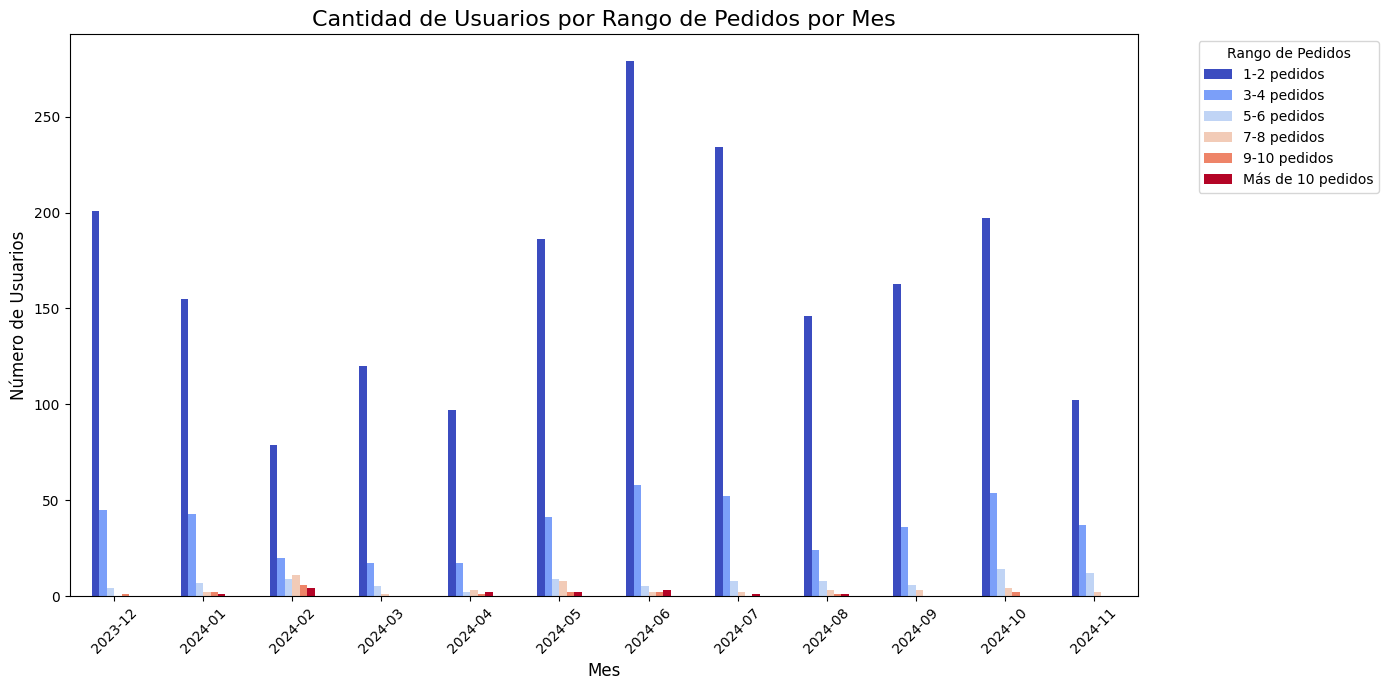

In [10]:
plt.figure(figsize=(12, 6))
cohorte_rango_pedidos_mes.plot(kind='bar', stacked=False, figsize=(14, 7), cmap='coolwarm')
# Añadir títulos y etiquetas
plt.title('Cantidad de Usuarios por Rango de Pedidos por Mes', fontsize=16)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Número de Usuarios', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Rango de Pedidos', bbox_to_anchor=(1.05, 1), loc='upper left')

# Guardar el gráfico en un archivo
plt.tight_layout()
plt.savefig('cohorte_rango_pedidos_mes.png')
plt.show()
